In [3]:
import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime as dt
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
import joblib
from sklearn.model_selection import train_test_split
from datetime import timedelta
from collections import Counter


# About Dataset
- Sample Rate = 25Hz
- Duration = 20 mins
- AF = 19 respondent
- Non-AF = 16 respondent
- n_data per pasien = 25Hz * (20m * 60s) = 30000 data per pasien
- Total data = 30000 * 35 pasien = 1050000. Tapi detik ke-0 juga diitung jadi = 1050035

In [4]:
df = pd.read_csv(r'ppg_af_dataset.csv')
# df = pd.read_csv(r'ppg_af_dataset_25hz.csv')
df

,time,ppg,ecg,resp,status
0,0.000,0.410557,0.314453,0.717097,0
1,0.008,0.400782,0.285156,0.720787,0
2,0.016,0.391007,0.300781,0.723247,0
3,0.024,0.382209,0.304688,0.726937,0
4,0.032,0.372434,0.294922,0.730627,0
...,...,...,...,...,...
5250030,1199.968,0.472141,-0.189453,0.331378,1
5250031,1199.976,0.473118,-0.498047,0.334311,1
5250032,1199.984,0.474096,-0.498047,0.337243,1
5250033,1199.992,0.474096,-0.359375,0.340176,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5250035 entries, 0 to 5250034
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   time    float64
 1   ppg     float64
 2   ecg     float64
 3   resp    float64
 4   status  int64  
dtypes: float64(4), int64(1)
memory usage: 200.3 MB


In [6]:
df.describe()

,time,ppg,ecg,resp,status
count,5.250035e+06,5.247136e+06,5.249660e+06,3.900026e+06,5.250035e+06
mean,6.000000e+02,9.497512e-01,4.150870e-01,2.368876e-01,5.428571e-01
std,3.464125e+02,7.359953e-01,2.779199e-01,4.592674e-01,4.981599e-01
min,0.000000e+00,0.000000e+00,-5.019608e-01,-1.846506e+00,0.000000e+00
25%,3.000000e+02,4.078431e-01,2.649071e-01,2.015883e-02,0.000000e+00
50%,6.000000e+02,5.503421e-01,4.257812e-01,2.355816e-01,1.000000e+00
75%,9.000000e+02,1.678397e+00,5.551758e-01,4.686347e-01,1.000000e+00
max,1.200000e+03,4.001955e+00,1.503937e+00,2.844215e+00,1.000000e+00


In [7]:
status_count = df['status'].value_counts()
status_count

status
1    2850019
0    2400016
Name: count, dtype: int64

In [8]:
# Pie chart (for percentage)
status = status_count.sort_index()
status_index = status.index
fig = px.pie(names=status_index, values=status, hole=0.3,
             labels={'names':'status'}, title='AF Status Distribution Pie Chart')
fig.update_traces(textposition='inside', textinfo='percent+label+value')
fig.show()


In [9]:
# df125.isna().sum()
df.isna().sum()

time            0
ppg          2899
ecg           375
resp      1350009
status          0
dtype: int64

In [10]:
# df125.isna().mean() * 100
df.isna().mean() * 100

time       0.000000
ppg        0.055219
ecg        0.007143
resp      25.714286
status     0.000000
dtype: float64

# Visualize signal on specific range

In [11]:
def show_wave_from(df, pasien_ke=1, s_start=0, s_stop=10, fitur='ppg', af_status=0, sample_rate=125):
    lama_ukur = 1200 # 20m = 1200s
    sample_per_pasien = lama_ukur * sample_rate
    duration = s_stop - s_start

    if 0 <= s_start <= lama_ukur and 0 <= s_stop <= lama_ukur:
        if af_status == 0 and 1 <= pasien_ke <= 16:
            afdf = df[df['status'] == 0]
        elif af_status == 1 and 1 <= pasien_ke <= 19:
            afdf = df[df['status'] == 1]
        else:
            print('Invalid nomor pasien atau sample time')

        dfpasien = afdf[(pasien_ke - 1) * sample_per_pasien : pasien_ke * sample_per_pasien]
        dfintvl = dfpasien[sample_rate*s_start : (sample_rate*s_stop)+1]
            
        x_ax = dfintvl['time']
        y_ax = dfintvl[fitur]

        plt.figure(figsize=(16, 4))
        plt.plot(x_ax, y_ax)
        plt.title(f'Gelombang {fitur} dari pasien ke-{pasien_ke} dari {s_start} - {s_stop} detik')

        step = s_start
        for t in range(duration):
            step += 1
            plt.axvline(x=step, color='gray', linestyle='--', linewidth=0.8)

        plt.show()

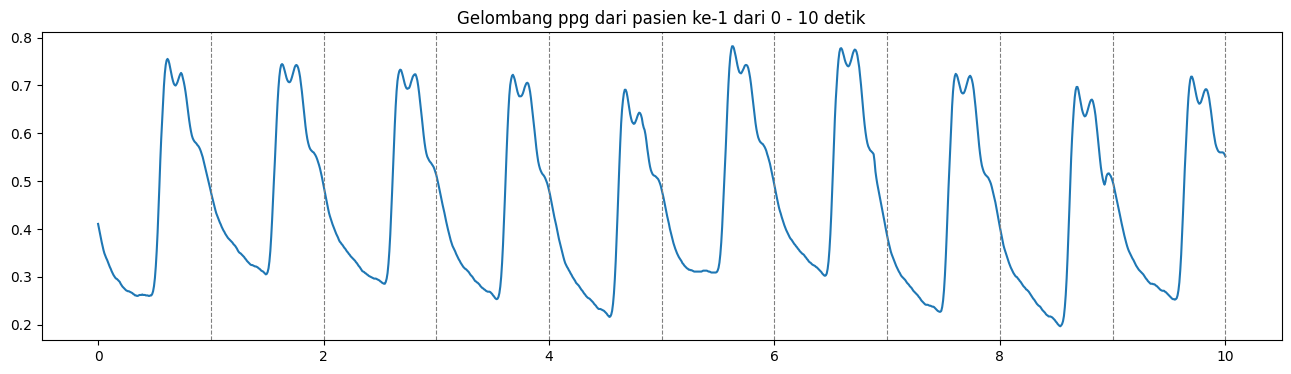

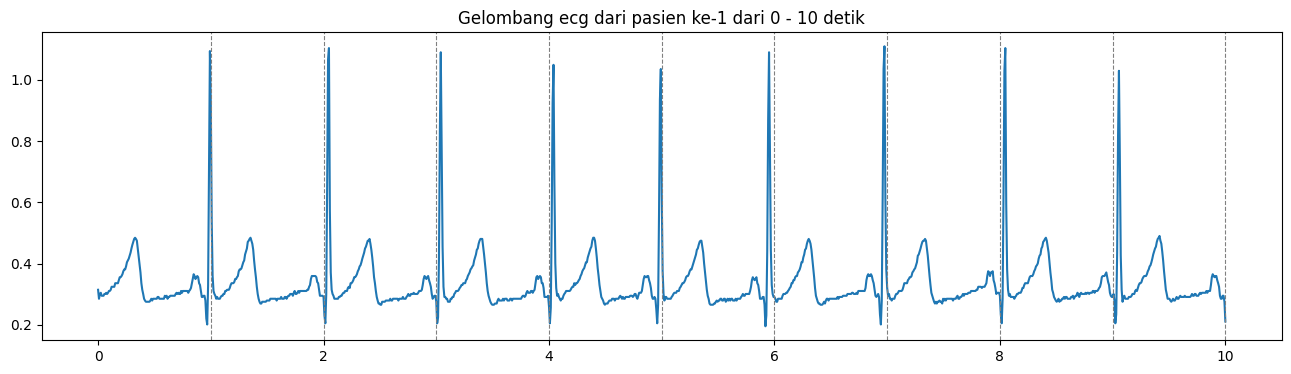

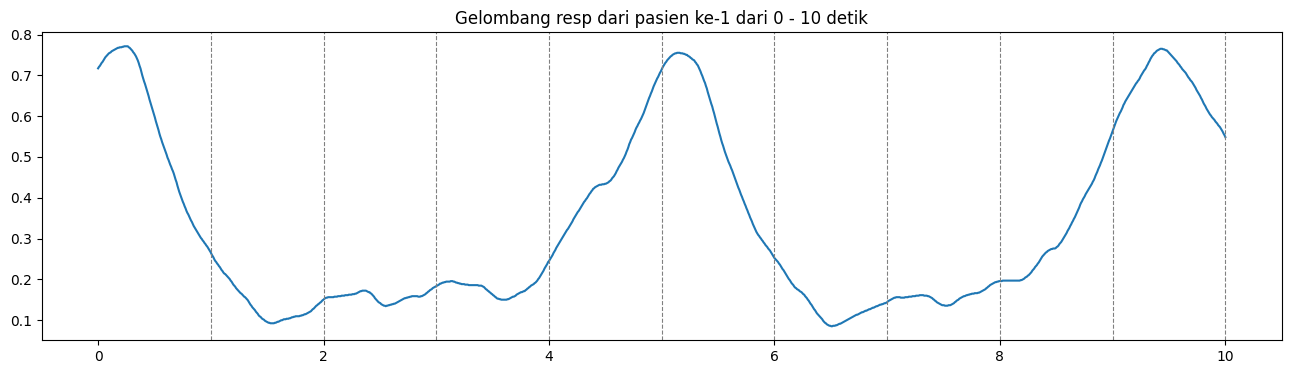

In [12]:
for i in df.columns[1:-1]:
    show_wave_from(df, fitur=i, sample_rate=125)

# AF VS Non-AF Wave

Non-AF Wave:


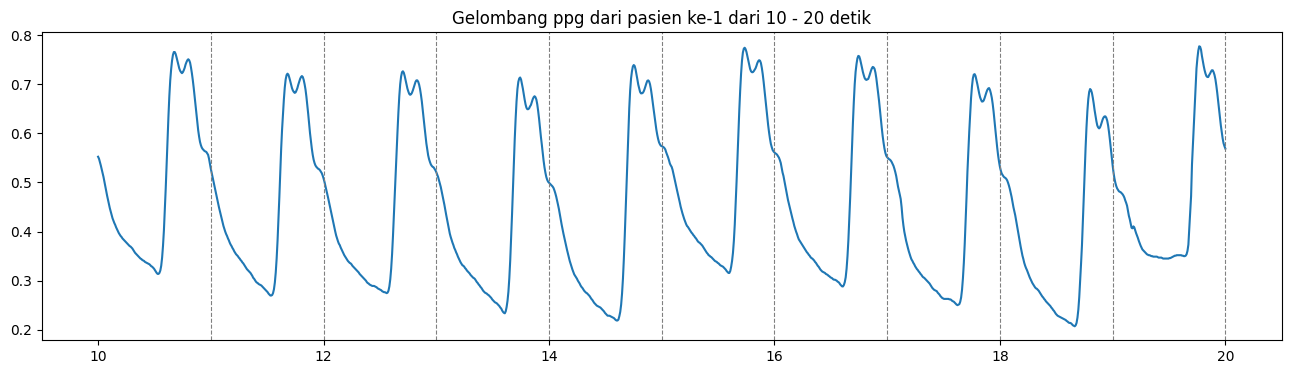

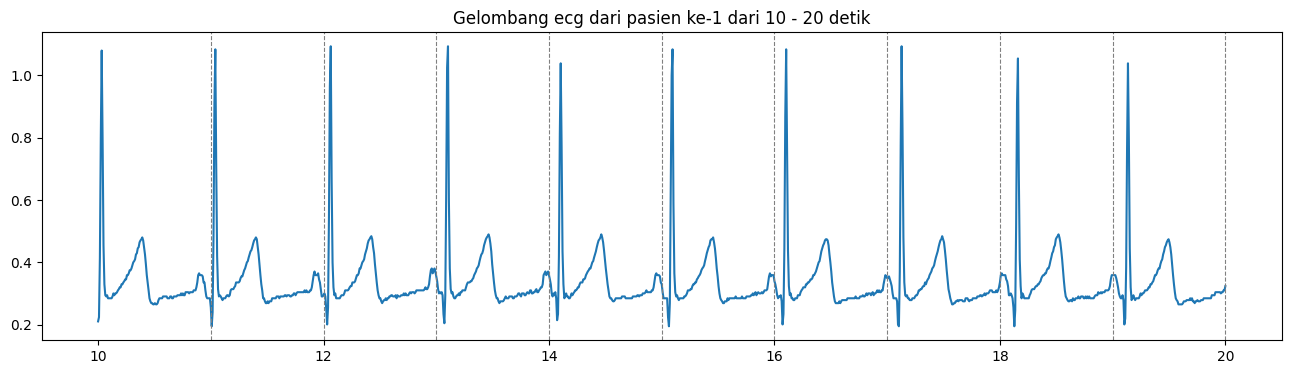

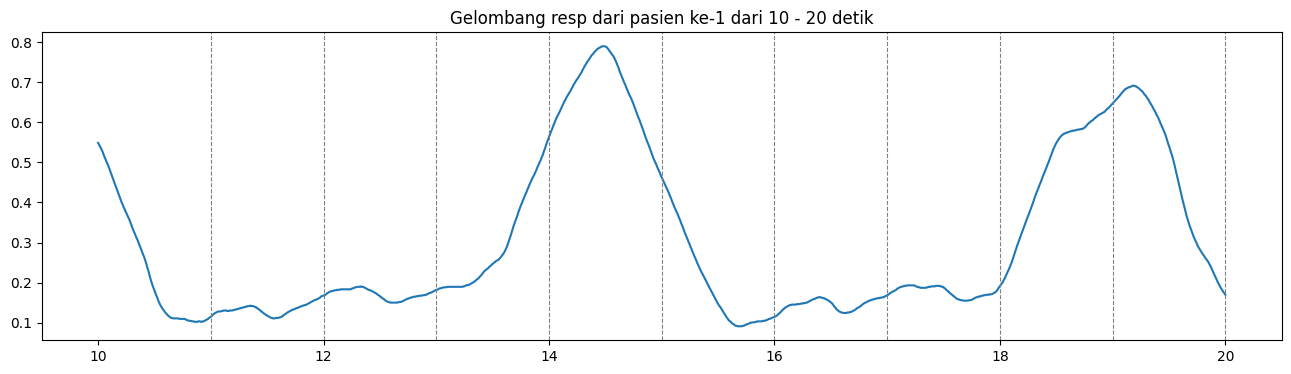

AF Wave:


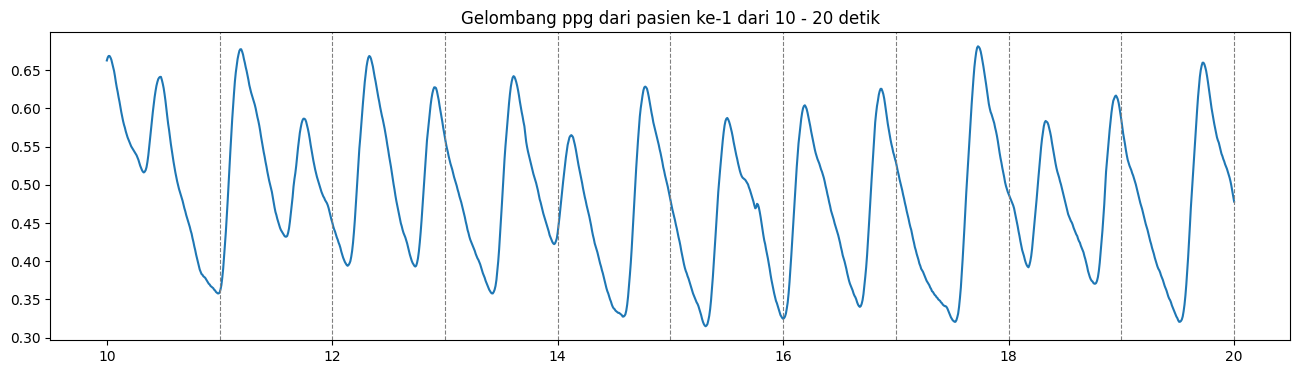

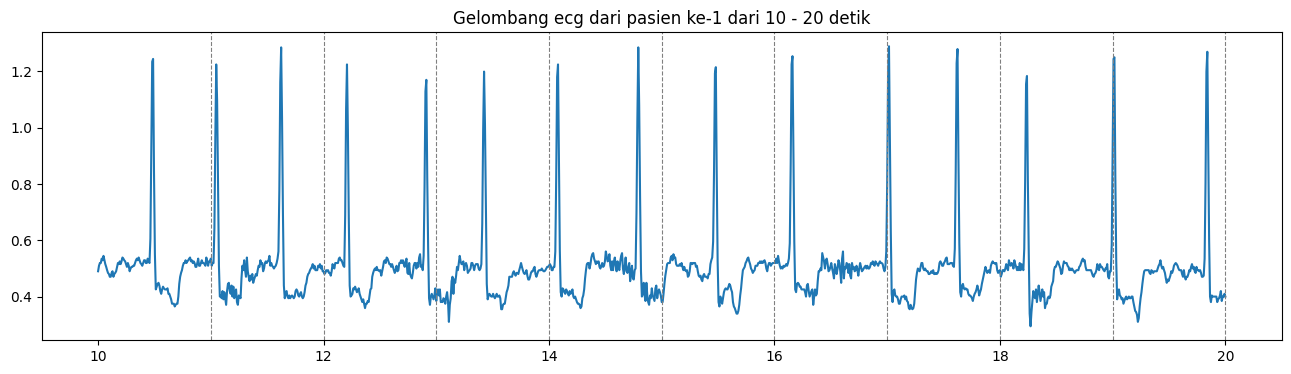

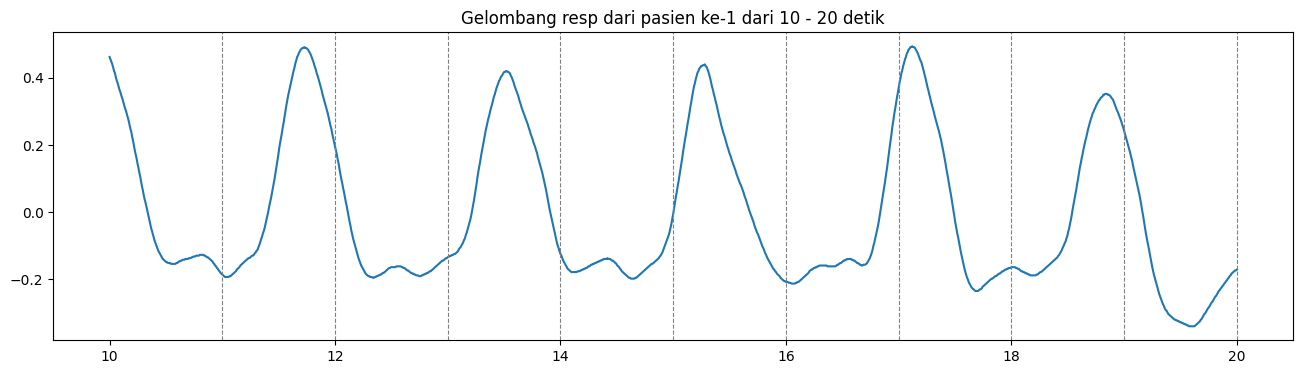

In [13]:
print('Non-AF Wave:')
for i in df.columns[1:-1]:
    show_wave_from(df, sample_rate=125, pasien_ke=1, s_start=10, s_stop=20, af_status=0, fitur=i)

print('AF Wave:')
for i in df.columns[1:-1]:
    show_wave_from(df, sample_rate=125, pasien_ke=1, s_start=10, s_stop=20, af_status=1, fitur=i)

# Imputation: Interpolation

In [14]:
df['ppg'] = df['ppg'].interpolate()
df.isna().sum()

time            0
ppg             0
ecg           375
resp      1350009
status          0
dtype: int64

# Feature Selection

In [15]:
df.drop(['ecg', 'resp'], axis=1, inplace=True)
df

,time,ppg,status
0,0.000,0.410557,0
1,0.008,0.400782,0
2,0.016,0.391007,0
3,0.024,0.382209,0
4,0.032,0.372434,0
...,...,...,...
5250030,1199.968,0.472141,1
5250031,1199.976,0.473118,1
5250032,1199.984,0.474096,1
5250033,1199.992,0.474096,1


# Set Window Size

In [16]:
# Jml baris data klo segmentasi per detik
print(len(df['ppg']))
n_windows = len(df['ppg']) // 125
n_windows

5250035


42000

In [17]:
df['ppg']

0          0.410557
1          0.400782
2          0.391007
3          0.382209
4          0.372434
             ...   
5250030    0.472141
5250031    0.473118
5250032    0.474096
5250033    0.474096
5250034    0.473118
Name: ppg, Length: 5250035, dtype: float64

In [18]:
sampling_rate = 125
window_size = sampling_rate    # 125 segment
ppg_signal = df['ppg'].values
n_windows = len(ppg_signal) // window_size # 1050035 data row

ppg_windows = []
for i in range(n_windows):
    start = i * window_size
    end = start + window_size
    window = ppg_signal[start:end]
    ppg_windows.append(window)

df_window = pd.DataFrame(ppg_windows)
df_window

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,0.410557,0.400782,0.391007,0.382209,0.372434,0.363636,0.355816,0.348974,0.344086,0.339198,...,0.556207,0.550342,0.542522,0.534702,0.526882,0.519062,0.511241,0.503421,0.494624,0.486804
1,0.478006,0.470186,0.462366,0.454545,0.446725,0.439883,0.433040,0.428152,0.423265,0.418377,...,0.557185,0.554252,0.550342,0.545455,0.539589,0.533724,0.526882,0.519062,0.510264,0.500489
2,0.490714,0.480938,0.470186,0.460411,0.451613,0.442815,0.434018,0.427175,0.421310,0.415445,...,0.551320,0.547410,0.543500,0.540567,0.538612,0.535679,0.532747,0.529814,0.524927,0.519062
3,0.513196,0.505376,0.496579,0.487781,0.478983,0.469208,0.459433,0.450635,0.442815,0.434018,...,0.525904,0.521017,0.517107,0.514174,0.512219,0.509286,0.505376,0.500489,0.495601,0.488759
4,0.480938,0.473118,0.463343,0.454545,0.443793,0.434018,0.424242,0.416422,0.407625,0.397849,...,0.514174,0.512219,0.511241,0.510264,0.508309,0.506354,0.504399,0.500489,0.495601,0.489736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0.456500,0.451613,0.448680,0.444770,0.442815,0.440860,0.440860,0.440860,0.440860,0.441838,...,0.626588,0.613881,0.600196,0.586510,0.572825,0.558162,0.544477,0.531769,0.520039,0.511241
41996,0.504399,0.498534,0.492669,0.488759,0.486804,0.483871,0.481916,0.480938,0.478983,0.478983,...,0.372434,0.372434,0.372434,0.372434,0.372434,0.372434,0.372434,0.372434,0.372434,0.371457
41997,0.371457,0.371457,0.371457,0.371457,0.371457,0.371457,0.372434,0.375367,0.380254,0.390029,...,0.514174,0.534702,0.556207,0.572825,0.582600,0.588465,0.592375,0.592375,0.590420,0.586510
41998,0.581623,0.575758,0.567937,0.560117,0.551320,0.541544,0.530792,0.518084,0.507331,0.495601,...,0.415445,0.412512,0.409580,0.406647,0.403715,0.399804,0.395894,0.393939,0.391007,0.390029


In [19]:
# jml kolom
len(df_window.iloc[0,:])

125

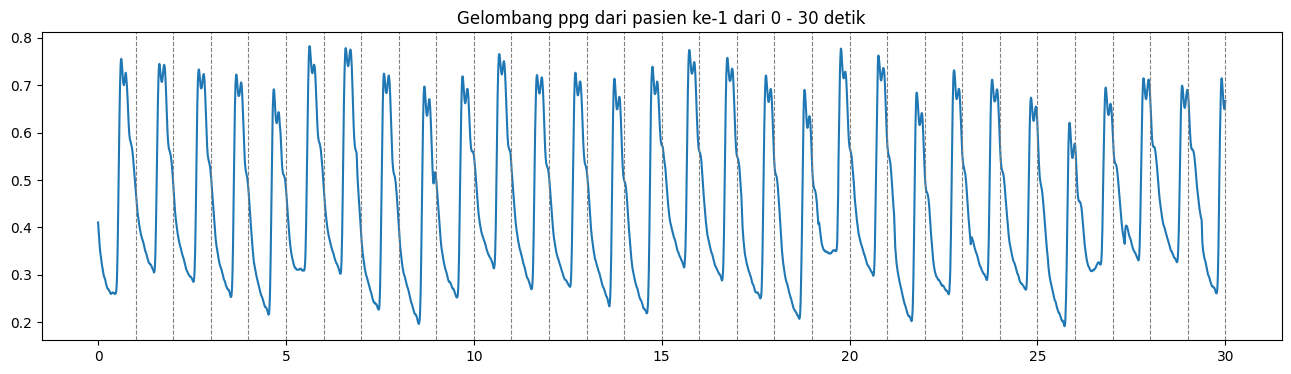

In [20]:
# Visualize ppg 30s (1 row df_window)
show_wave_from(df, sample_rate=125, s_start=0, s_stop=30)

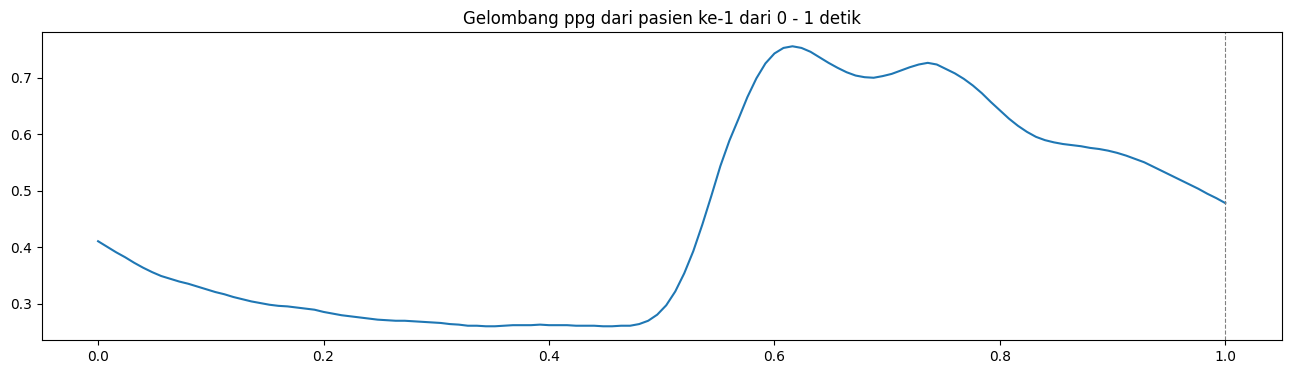

In [21]:
show_wave_from(df, sample_rate=125, s_start=0, s_stop=1)

In [22]:
df_window.iloc[:,0].describe()

count    42000.000000
mean         0.950050
std          0.734075
min          0.000000
25%          0.410557
50%          0.552941
75%          1.675464
max          4.001955
Name: 0, dtype: float64

In [23]:
df_window.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 125 entries, 0 to 124
dtypes: float64(125)
memory usage: 40.1 MB


# Add Label

In [24]:
status_array = df['status'].values
df_label = []

# Vote majority label per window
for i in range(n_windows):
    start = i * window_size
    end = start + window_size
    window_status = status_array[start:end]
    label = mode(window_status, keepdims=False).mode
    df_label.append(label)

df_label = pd.Series(df_label)
df_label

0        0
1        0
2        0
3        0
4        0
        ..
41995    1
41996    1
41997    1
41998    1
41999    1
Length: 42000, dtype: int64

In [25]:
df_label[df_label==1]

19200    1
19201    1
19202    1
19203    1
19204    1
        ..
41995    1
41996    1
41997    1
41998    1
41999    1
Length: 22800, dtype: int64

# Train Test Split

In [26]:
X_train, X_temp, y_train, y_temp = train_test_split(df_window, df_label, test_size=0.3, random_state=7, stratify=df_label)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

X_test

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
21268,0.278431,0.301961,0.329412,0.364706,0.403922,0.443137,0.486275,0.521569,0.556863,0.588235,...,0.243137,0.243137,0.247059,0.247059,0.247059,0.247059,0.250980,0.250980,0.250980,0.250980
40222,0.520039,0.520039,0.520039,0.519062,0.518084,0.517107,0.515152,0.513196,0.511241,0.509286,...,0.497556,0.496579,0.494624,0.493646,0.492669,0.491691,0.490714,0.489736,0.488759,0.488759
13682,0.662745,0.654902,0.650980,0.650980,0.647059,0.647059,0.647059,0.647059,0.647059,0.650980,...,0.682353,0.682353,0.682353,0.682353,0.682353,0.682353,0.682353,0.682353,0.682353,0.682353
29424,0.512219,0.506354,0.501466,0.495601,0.490714,0.486804,0.482893,0.479961,0.477028,0.475073,...,0.451613,0.450635,0.449658,0.449658,0.449658,0.449658,0.449658,0.450635,0.450635,0.451613
40942,0.441838,0.436950,0.434995,0.436950,0.440860,0.447703,0.456500,0.464321,0.469208,0.470186,...,0.000000,0.000000,0.000000,0.000978,0.007820,0.021505,0.040078,0.059629,0.082111,0.105572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16982,0.580392,0.572549,0.568627,0.560784,0.556863,0.549020,0.541176,0.537255,0.529412,0.521569,...,0.352941,0.349020,0.349020,0.345098,0.345098,0.341176,0.337255,0.337255,0.333333,0.333333
749,0.497556,0.491691,0.484848,0.477028,0.468231,0.459433,0.449658,0.439883,0.430108,0.421310,...,0.508309,0.503421,0.500489,0.498534,0.496579,0.495601,0.493646,0.491691,0.486804,0.481916
9590,0.662745,0.643137,0.623529,0.603922,0.584314,0.560784,0.541176,0.521569,0.501961,0.482353,...,0.407843,0.403922,0.396078,0.392157,0.384314,0.376471,0.368627,0.364706,0.356863,0.349020
19587,0.633431,0.638319,0.641251,0.641251,0.638319,0.633431,0.627566,0.620723,0.612903,0.604106,...,0.481916,0.476051,0.471163,0.465298,0.461388,0.457478,0.452590,0.446725,0.440860,0.434995


# Preprocess Pipeline

In [27]:
X_train_prep = X_train
X_val_prep  = X_val
X_test_prep = X_test

In [28]:
# Transformer buat reshape 2D jadi 3D
class ReshapeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=12):
        self.n_features = n_features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # reshape jadi 3D
        return np.reshape(X, (X.shape[0], self.n_features, 1))

In [29]:
X_train_prep.shape

(29400, 125)

# LSTM Model

In [30]:
def build_model(input_shape=125):
    model = Sequential([
        Input(shape=(input_shape, 1)),
        LSTM(64),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'recall'])
    return model

# Train LSTM Only

In [31]:
# Cek sebelumnya udah ada model yg disave lom (yg format h5)
os.makedirs(r'models', exist_ok=True)
timestamp = dt.now().strftime('%d%m%Y_%H%M%S')
model_path = f'models/model_{timestamp}.h5'
log_path = r'model_log.csv'

existing_models = sorted(glob.glob('models/*.h5'))
smallest_prev_loss = np.inf
best_model_file = None
existing_models

['models\\best_model.h5',
 'models\\model-20250926_104642.h5',
 'models\\model_01102025_212752.h5',
 'models\\model_02102025_230946.h5',
 'models\\model_05102025_225139.h5',
 'models\\model_20250926_104642.h5',
 'models\\model_28092025_203908.h5',
 'models\\model_28092025_215429.h5',
 'models\\model_d102025_144557.h5',
 'models\\model_d102025_192017.h5']

In [32]:
# Cari best model dari model yg udah ada di log_path.csv, cari loss terkecil
if os.path.exists(log_path):
    df_log = pd.read_csv(log_path)

    # Klo udah ada yg disave sebelumnya
    if not df_log.empty:
        best_model = df_log.sort_values(by='val_loss').iloc[0]
        smallest_prev_loss = best_model['val_loss']
        best_model_file = best_model['filename']
else:
    df_log = pd.DataFrame

best_model

filename    models/model_d102025_192017.h5
val_loss                          0.143445
Name: 6, dtype: object

In [33]:
if best_model_file and os.path.exists(best_model_file):
    print(f'Loading previous best model from {best_model_file}')
    model = load_model(best_model_file)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'recall'])
else:
    print('No previous model found of file missing. Building new model')
    model = build_model()
model

Loading previous best model from models/model_d102025_192017.h5


<Sequential name=sequential_1, built=True>

## Bisa comment mulai sini buat disable training
sampe sebelum masuk hybrid

In [34]:
# # Train
# tf.compat.v1.enable_eager_execution()
# history = model.fit(
#     X_train_prep, y_train,
#     epochs=60,
#     batch_size=64,
#     validation_data=(X_val_prep, y_val),
#     verbose=1
# )
# history

In [35]:
# # Plot recall, accuracy and loss
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['recall'], label='Train Recall')
# plt.plot(history.history['val_recall'], label='Val Recall')
# plt.title('Recall')
# plt.xlabel('Epoch')
# plt.ylabel('Recall')
# plt.legend()
# plt.grid(True)

# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Val Accuracy')
# plt.title('Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)

# # Plot loss
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 3, 3)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Val Loss')
# plt.title('Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()

In [36]:
# curr_loss = history.history['val_loss'][-1]
# print(f'Current model val_loss: {curr_loss:.4f}')

In [37]:
# # Save retrained model klo better (smaller val_loss)
# if curr_loss < smallest_prev_loss:
#     print(f'Saving better new model (val_loss {smallest_prev_loss:.4f} -> {curr_loss:.4f} as {model_path})')
#     model.save(model_path)
#     new_log = pd.DataFrame([[model_path, curr_loss]], columns=['filename', 'val_loss'])
#     df_log = pd.concat([df_log, new_log], ignore_index=True)
#     df_log.to_csv(log_path, index=False)
#     best_model_file = model_path
# else:
#     print(f'Keeping previous best model ({best_model_file}. val_loss: {smallest_prev_loss:.4f})')

In [38]:
# # Evaluate
# loss, acc, recall = model.evaluate(X_test_prep, y_test)


In [39]:
# y_pred_prob = model.predict(X_test_prep).ravel()
# y_pred = (y_pred_prob >= 0.5).astype(int) # convert langsung ke kategori label
# y_pred_prob

In [40]:
# acc = accuracy_score(y_test, y_pred)
# prec = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# roauc = roc_auc_score(y_test, y_pred_prob)

# print('LSTM Evaluation')
# print(f'Accuracy: {acc:.4f}')
# print(f"Precision: {prec:.4f}")
# print(f"Recall   : {recall:.4f}")
# print(f"F1 Score : {f1:.4f}")
# print(f"ROC AUC  : {roauc:.4f}")

# print(classification_report(y_test, y_pred))

In [41]:
# # ROC curve
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(8,6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
# plt.plot([0,1], [0,1], color='gray', linestyle='--', label='Random Guess (AUC = 0.5)')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [42]:
# # Confusion matrix lstm
# cm = confusion_matrix(y_test, y_pred)
# disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-AF', 'AF'])
# disp_cm.plot(cmap='Blues')

<!-- # XGBoost Model -->

In [43]:
# # Prepare
# preprocess_pipeline_xgb = Pipeline(steps=[
#     ('scaler', MinMaxScaler()),
#     # ('pca', PCA(n_components=n_comp_pca)),
# ])

In [44]:
# # Assign all preprocessing to data
# X_train_prep_xgb = preprocess_pipeline_xgb.fit_transform(X_train)
# X_val_prep_xgb = preprocess_pipeline_xgb.fit_transform(X_val)
# X_test_prep_xgb = preprocess_pipeline_xgb.fit_transform(X_test)

# X_train_prep_xgb.shape, X_val_prep_xgb.shape, X_test_prep_xgb.shape


# Train XGBoost Only

In [45]:
xgb = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=600,
    learning_rate=0.2,
    max_depth=9,
    subsample=0.8,
    colsample_bytree=0.8
    )

xgb.fit(X_train_prep, y_train)
xgb

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning:

[12:07:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=None,
              num_parallel_tree=None, ...)

In [46]:
y_pred_prob_xgb = xgb.predict_proba(X_test_prep)[:,1]
y_pred = xgb.predict(X_test_prep)
y_pred_prob_xgb

array([9.9254757e-01, 9.9980432e-01, 1.2790057e-01, ..., 5.4957258e-05,
       9.9854147e-01, 9.9964130e-01], dtype=float32)

In [47]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roauc = roc_auc_score(y_test, y_pred_prob_xgb)

print('XGBoost Evaluation')
print(f'Accuracy: {acc:.4f}')
print(f"Precision: {prec:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roauc:.4f}")

print(classification_report(y_test, y_pred))

XGBoost Evaluation
Accuracy: 0.8943
Precision: 0.8912
Recall   : 0.9173
F1 Score : 0.9040
ROC AUC  : 0.9585
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      2880
           1       0.89      0.92      0.90      3420

    accuracy                           0.89      6300
   macro avg       0.89      0.89      0.89      6300
weighted avg       0.89      0.89      0.89      6300



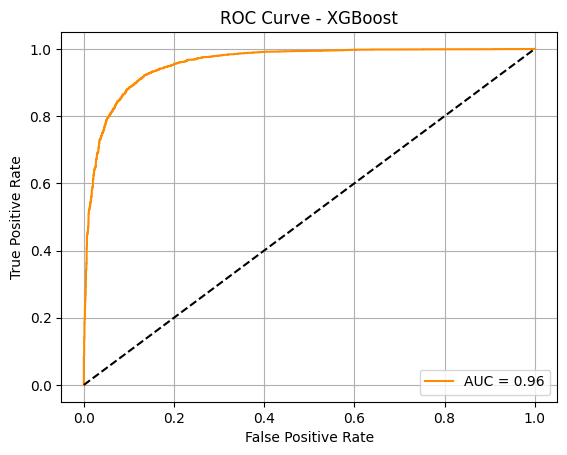

In [48]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_xgb)
plt.plot(fpr, tpr, label=f"AUC = {roauc:.2f}", color='darkorange')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.grid(True)
plt.show()


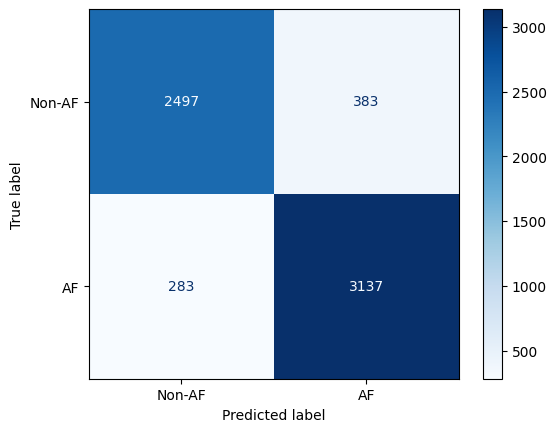

In [49]:
# Confusion matrix xgb
cm = confusion_matrix(y_test, y_pred)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-AF', 'AF'])
disp_cm.plot(cmap='Blues')

## Disable train sampe sini

# Hybrid Model

## LSTMX: LSTM Feature Extractor

In [50]:
# Transformer LSTM Xtractor pipeline
class LSTMX(BaseEstimator, TransformerMixin):
    def __init__(self, lstm):
        self.lstm = lstm

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return self.lstm.predict(X)

In [51]:
best_model_file

'models/model_d102025_192017.h5'

In [52]:
X_train.shape

(29400, 125)

In [53]:
# # Rebuild architecture, ambil output last hidden layer
# input_layer = Input(shape=(X_train.shape[1],1))
# x = LSTM(64, name='lstm_layer')(input_layer)
# x = Dropout(0.3, name='dropout_layer')(x)
# x = Dense(32, activation='relu', name='last_dense')(x)
# output_layer = Dense(1, activation='sigmoid', name='output_layer')(x)

# lstm = Model(inputs=input_layer, outputs=output_layer)
# lstm.load_weights(best_model_file)
# lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'recall'])
# lstm_last_dense = Model(inputs=lstm.input, outputs=lstm.get_layer('last_dense').output)
# acc, loss, recall = lstm.evaluate(X_test, y_test)

In [54]:
# Rebuild architecture, ambil output last hidden layer

input_shape = (X_train.shape[1], 1)
lstm = Sequential(name="LSTM_Sequential")

lstm.add(LSTM(64, input_shape=input_shape, name='lstm_layer'))
lstm.add(Dropout(0.3, name='dropout_layer'))
lstm.add(Dense(32, activation='relu', name='last_dense'))
lstm.add(Dense(1, activation='sigmoid', name='output_layer'))

lstm.load_weights(best_model_file)
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'recall'])

# Buat model feature extractor 
lstm_last_dense = Model(inputs=lstm.inputs, outputs=lstm.get_layer('last_dense').output)
acc, loss, recall = lstm.evaluate(X_test, y_test)

lstm_last_dense.summary()

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9404 - loss: 0.1474 - recall: 0.9381


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 125, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_dense (Dense)              │ (None, 32)             │         2,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,976 (74.12 KB)

 Trainable params: 18,976 (74.12 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
lstm_last_dense.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 125, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_dense (Dense)              │ (None, 32)             │         2,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,976 (74.12 KB)

 Trainable params: 18,976 (74.12 KB)

 Non-trainable params: 0 (0.00 B)

Ini arsitekturnya kita rebuild, bukan load_model() dari best lstm yang udah ada karena klo load_model() itu langsung dapet semua gabisa dicustom otak-atik. Klo pake load_model(), arsitekturnya gabisa diubah, termasuk compiler sama metric evaluation nya juga. Di sini kita mau ngutik hidden layer terakhir buat dinamain biar bisa dipanggil buat ngasilin output last hidden layer, bukan hasil output_layer yang udah hasil prediksi final

In [56]:
pipeline_lstmx = Pipeline(steps=[('reshaper', ReshapeTransformer(n_features=125)), ('lstmx', LSTMX(lstm_last_dense))])
X_train_xtract = pipeline_lstmx.transform(X_train_prep)
X_test_xtract = pipeline_lstmx.transform(X_test_prep)
X_train_xtract.shape, X_test_xtract.shape

  1/919 ━━━━━━━━━━━━━━━━━━━━ 3:11 208ms/step

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_10']
Received: inputs=Tensor(shape=(32, 125, 1))



917/919 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_10']
Received: inputs=Tensor(shape=(None, 125, 1))



919/919 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step


((29400, 32), (6300, 32))

In [57]:
X_train_prep.shape

(29400, 125)

In [58]:
reshape_pipeline = Pipeline(steps=[('reshaper', ReshapeTransformer(n_features=125))])
X_train_reshaped = reshape_pipeline.transform(X_train_prep)
X_test_reshaped = reshape_pipeline.transform(X_test_prep)
X_train_reshaped.shape

(29400, 125, 1)

In [59]:
X_train_xtract = lstm_last_dense.predict(X_train_reshaped)
X_test_xtract = lstm_last_dense.predict(X_test_reshaped)
X_train_xtract.shape, X_test_xtract.shape

919/919 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


((29400, 32), (6300, 32))

## Fuse XGBoost

## Grid Search


In [60]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [7, 9, 11, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8]
}

In [61]:
# hybrid = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=77)

# grid_search = GridSearchCV(
#     estimator=xgb,          
#     param_grid=param_grid,  
#     scoring='roc_auc',      
#     cv=3,                   
#     verbose=2,              
#     n_jobs=-1               
# )

In [62]:
# print("Starting GridSearchCV...")
# grid_search.fit(X_train_xtract, y_train)
# print("GridSearchCV Done")

In [63]:
# print("Parameter terbaik:", grid_search.best_params_)
# print("Skor cross-validation terbaik:", grid_search.best_score_)

# best_hybrid = grid_search.best_estimator_

## Train Hybrid

In [64]:
best_hybrid = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=9,
    use_label_encoder=False,
    random_state=42,
    eval_metric='logloss',
    subsample=0.8,
    colsample_bytree=0.7
    )

best_hybrid.fit(X_train_xtract, y_train)
best_hybrid

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning:

[12:08:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [65]:
y_prob_hybrid = best_hybrid.predict_proba(X_test_xtract)[:,1]
y_pred = best_hybrid.predict(X_test_xtract)
y_prob_hybrid

array([0.99613345, 0.9963223 , 0.18419622, ..., 0.00394616, 0.9963116 ,
       0.9963223 ], dtype=float32)

In [66]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roauc = roc_auc_score(y_test, y_prob_hybrid)

print('Hybrid Evaluation')
print(f'Accuracy: {acc:.4f}')
print(f"Precision: {prec:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roauc:.4f}")

print(classification_report(y_test, y_pred))

Hybrid Evaluation
Accuracy: 0.9444
Precision: 0.9467
Recall   : 0.9512
F1 Score : 0.9489
ROC AUC  : 0.9869
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2880
           1       0.95      0.95      0.95      3420

    accuracy                           0.94      6300
   macro avg       0.94      0.94      0.94      6300
weighted avg       0.94      0.94      0.94      6300



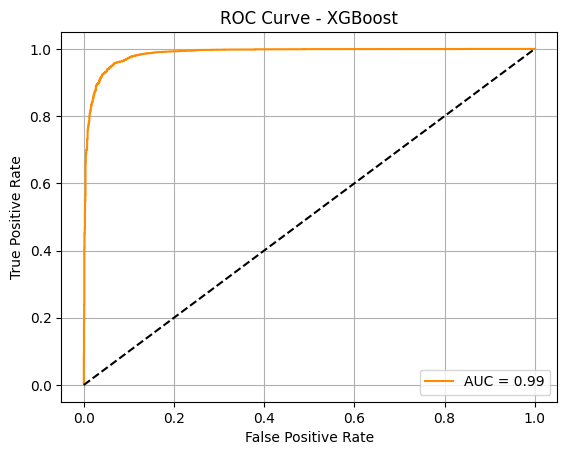

In [67]:
fpr, tpr, _ = roc_curve(y_test, y_prob_hybrid)
plt.plot(fpr, tpr, label=f"AUC = {roauc:.2f}", color='darkorange')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.grid(True)
plt.show()

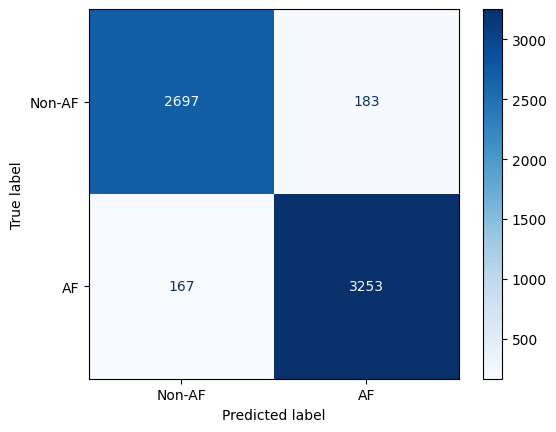

In [68]:
# Confusion matrix hybrid
cm = confusion_matrix(y_test, y_pred)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-AF', 'AF'])
disp_cm.plot(cmap='Blues')

Previous: lstm acc 93.8%, loss 0.251, hybrid acc 92.22%
Now: lstm acc 92.92%, loss 0.1503, hybrid acc 94.94%

# SAVE ALL

In [69]:
# # Target directory
# os.makedirs('model_deploy', exist_ok=True)
# timestamp = dt.now().strftime('%d%m%Y_%H%M%S')

# # Preprocessing pipeline: MinMaxScaler, PCA, ReshapeTransformer (pkl)
# # path_prep = f'model_deploy/{timestamp}_preprocess.pkl'
# # joblib.dump(preprocess_pipeline, path_prep)
# # print("1. Preprocessing pipeline successfully saved.")

# # Reshaper for input LSTM (pkl)
# path_reshaper = f'model_deploy/{timestamp}_reshaper.pkl'
# joblib.dump(reshape_pipeline, path_reshaper)
# print("1. Reshaper has been successfully saved.")

# # LSTM Model for feature extraction (h5)
# path_lstx = f'model_deploy/{timestamp}_lstmx.h5'
# lstm_last_dense.save(path_lstx)
# print("2. LSTMX pipeline successfully saved.")

# # Hybrid LSTM-XGBoost (json)
# path_hybrid = f'model_deploy/{timestamp}_hybrid_lxgb.json'
# best_hybrid.save_model(path_hybrid)
# print("3. Hybrid model successfully saved.")

<!-- # Contoh cara pake buat prediksi -->

In [70]:
# # --- Load semua komponen ---
# loaded_preprocessor = joblib.load(path_prep)
# loaded_feature_extractor = tf.keras.models.load_model(path_lstx)
# loaded_xgb_model = XGBClassifier()
# loaded_xgb_model.load_model(path_hybrid)


# # --- Buat fungsi prediksi end-to-end ---
# def predict_hybrid_system(data_mentah):
#     """
#     Fungsi ini menjalankan data mentah melalui seluruh alur hybrid.
#     """
#     # Pastikan input adalah 2D
#     if data_mentah.ndim == 1:
#         data_mentah = data_mentah.reshape(1, -1)
        
#     # 1. Jalankan preprocessing
#     data_processed = loaded_preprocessor.transform(data_mentah)
    
#     # 2. Ekstrak fitur dengan LSTM
#     fitur_lstm = loaded_feature_extractor.predict(data_processed)
    
#     # 3. Lakukan prediksi akhir dengan XGBoost
#     prediksi_final = loaded_xgb_model.predict(fitur_lstm)
#     probabilitas = loaded_xgb_model.predict_proba(fitur_lstm)
    
#     return prediksi_final[0], probabilitas[0]


# # --- Uji coba pada satu sampel data mentah ---
# # Ambil satu sampel dari X_test MENTAH (sebelum diproses)
# contoh_data = X_test_mentah[0] 

# hasil, prob = predict_hybrid_system(contoh_data)

# print(f"\n--- Hasil Prediksi pada Data Baru ---")
# print(f"Prediksi Kelas: {hasil} (0=Non-AF, 1=AF)")
# print(f"Probabilitas [Non-AF, AF]: [{prob[0]:.4f}, {prob[1]:.4f}]")